# Исследование октреотида

### Импорт сторонних библиотек

In [4]:
import re
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

### Загрузка данных

In [66]:
df = pd.read_excel(
    'база пациентов_редактированная.xls',
    # dtype={'year': 'Int64'}
    )
df.shape

(664, 32)

In [6]:
df.head(5)

,id,Сутки н/з,Возраст,Пол,APACHE-2,температура,пульс,АД ср,ЧД,ШКГ,...,Натрий,Глюкоза крови,Диастаза мочи,Амилаза крови,антибиотик,квамател,октреотид,раннее питание,познее питание,Летальность
0,5,1.0,23.0,мужской,10,36.0,118.0,116.0,28.0,15.0,...,138.0,7.9,2048.0,3142.0,Карбопенемы,да,да,да,нет,нет
1,327,1.0,65.0,мужской,9,37.4,94.0,120.0,24.0,15.0,...,136.0,10.6,NaN,1900.0,Карбопенемы,нет,да,да,нет,да
2,374,1.0,53.0,мужской,4,36.6,82.0,127.0,16.0,15.0,...,137.0,6.5,NaN,NaN,Карбопенемы,да,да,да,нет,нет
3,349,1.0,53.0,женский,9,36.4,105.0,107.0,16.0,15.0,...,136.0,6.0,91.0,NaN,Карбопенемы,да,нет,да,нет,нет
4,128,4.0,23.0,мужской,14,NaN,110.0,110.0,26.0,15.0,...,131.0,12.0,16.0,NaN,Карбопенемы,да,да,да,нет,да


### Data Preparation

##### 1. Список колонок датасета

In [7]:
df.columns

Index(['id', 'Сутки н/з', 'Возраст', 'Пол', 'APACHE-2', 'температура', 'пульс',
       'АД ср', 'ЧД', 'ШКГ', 'Гематокрит', 'Лейкоциты', 'П/я', 'Юные',
       'Лимфоциты', 'Общ белок (г/л)', 'Билирубин общ', 'АСТ', 'АЛТ',
       'Мочевина', 'Креатинин', 'Калий', 'Натрий', 'Глюкоза крови',
       'Диастаза мочи', 'Амилаза крови', 'антибиотик', 'квамател', 'октреотид',
       'раннее питание', 'познее питание', 'Летальность'],
      dtype='object')

##### 2. Описательные статистики датасета

In [8]:
df.describe(include=[object])

,Пол,антибиотик,квамател,октреотид,раннее питание,познее питание,Летальность
count,663,664,664,664,664,664,664
unique,2,7,2,2,2,2,2
top,мужской,Фтрохинолоны,нет,нет,нет,нет,нет
freq,468,222,359,377,442,551,474


In [9]:
df.describe(exclude=[object])

,id,Сутки н/з,Возраст,APACHE-2,температура,пульс,АД ср,ЧД,ШКГ,Гематокрит,...,Билирубин общ,АСТ,АЛТ,Мочевина,Креатинин,Калий,Натрий,Глюкоза крови,Диастаза мочи,Амилаза крови
count,664.000000,644.000000,662.000000,664.000000,657.000000,642.000000,618.000000,539.000000,661.000000,478.000000,...,541.000000,555.000000,554.000000,549.000000,522.000000,435.000000,432.000000,532.000000,436.000000,378.000000
mean,359.082831,7.734472,47.898792,6.533133,37.167428,97.973520,95.678867,20.408163,14.877458,39.379707,...,23.468447,109.774955,87.042599,7.683188,1.560582,3.824207,136.330556,7.709774,438.667431,482.294524
std,216.657693,11.561291,16.319717,4.598392,0.865799,20.483719,21.755140,5.172167,0.581370,8.946090,...,25.294355,254.250027,171.483922,6.299359,4.135740,0.870908,6.462901,4.686952,895.469767,768.942310
min,1.000000,1.000000,18.000000,0.000000,33.600000,43.000000,13.300000,12.000000,8.000000,15.400000,...,3.600000,6.800000,2.000000,1.000000,0.057000,1.400000,101.000000,2.200000,2.000000,6.030000
25%,170.750000,1.000000,35.250000,3.000000,36.600000,81.000000,86.000000,18.000000,15.000000,34.000000,...,10.000000,30.500000,22.250000,4.000000,0.800000,3.200000,133.000000,4.875000,42.500000,81.250000
50%,352.500000,3.000000,46.000000,6.000000,36.900000,96.000000,96.600000,19.000000,15.000000,39.000000,...,14.000000,56.000000,42.000000,5.700000,0.935000,3.900000,137.000000,6.200000,128.000000,216.250000
75%,518.250000,10.000000,57.000000,9.000000,37.700000,112.000000,110.000000,22.000000,15.000000,45.000000,...,25.000000,103.300000,84.750000,9.000000,1.300000,4.400000,140.000000,8.600000,512.000000,573.600000
max,741.000000,164.000000,94.000000,24.000000,42.000000,162.000000,150.000000,80.000000,15.000000,84.000000,...,212.000000,3880.000000,2930.000000,63.600000,66.000000,6.900000,153.000000,34.600000,9960.000000,9378.000000


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 664 entries, 0 to 663
Data columns (total 32 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               664 non-null    int64  
 1   Сутки н/з        644 non-null    float64
 2   Возраст          662 non-null    float64
 3   Пол              663 non-null    object 
 4   APACHE-2         664 non-null    int64  
 5   температура      657 non-null    float64
 6   пульс            642 non-null    float64
 7   АД ср            618 non-null    float64
 8   ЧД               539 non-null    float64
 9   ШКГ              661 non-null    float64
 10  Гематокрит       478 non-null    float64
 11  Лейкоциты        648 non-null    float64
 12  П/я              625 non-null    float64
 13  Юные             623 non-null    float64
 14  Лимфоциты        635 non-null    float64
 15  Общ белок (г/л)  547 non-null    float64
 16  Билирубин общ    541 non-null    float64
 17  АСТ             

Проверка на дубликаты

In [68]:
df[df.duplicated()]

,id,Сутки н/з,Возраст,Пол,APACHE-2,температура,пульс,АД ср,ЧД,ШКГ,...,Натрий,Глюкоза крови,Диастаза мочи,Амилаза крови,антибиотик,квамател,октреотид,раннее питание,познее питание,Летальность




Список всех признаков с пропущенными значениями:

In [69]:
exclude_list = ['ШКГ', 'Пол']
missing_values = ((df.isna().sum() / len(df)) * 100).sort_values(ascending=False)
missing_values_list = [column for column in missing_values[missing_values != 0].keys() if column not in exclude_list]
print(missing_values_list)

['Амилаза крови', 'Натрий', 'Калий', 'Диастаза мочи', 'Гематокрит', 'Креатинин', 'Глюкоза крови', 'ЧД', 'Билирубин общ', 'Общ белок (г/л)', 'Мочевина', 'АЛТ', 'АСТ', 'АД ср', 'Юные', 'П/я', 'Лимфоциты', 'пульс', 'Сутки н/з', 'Лейкоциты', 'температура', 'Возраст']


Заполнение пропущенных значений средним(количественные переменные)

In [70]:
for col in missing_values_list:
    df[col] = df[col].fillna(df[col].mean().item())
    print(f"Количество пропущенных значений в {col}:", df[col].isna().sum())

Количество пропущенных значений в Амилаза крови: 0
Количество пропущенных значений в Натрий: 0
Количество пропущенных значений в Калий: 0
Количество пропущенных значений в Диастаза мочи: 0
Количество пропущенных значений в Гематокрит: 0
Количество пропущенных значений в Креатинин: 0
Количество пропущенных значений в Глюкоза крови: 0
Количество пропущенных значений в ЧД: 0
Количество пропущенных значений в Билирубин общ: 0
Количество пропущенных значений в Общ белок (г/л): 0
Количество пропущенных значений в Мочевина: 0
Количество пропущенных значений в АЛТ: 0
Количество пропущенных значений в АСТ: 0
Количество пропущенных значений в АД ср: 0
Количество пропущенных значений в Юные: 0
Количество пропущенных значений в П/я: 0
Количество пропущенных значений в Лимфоциты: 0
Количество пропущенных значений в пульс: 0
Количество пропущенных значений в Сутки н/з: 0
Количество пропущенных значений в Лейкоциты: 0
Количество пропущенных значений в температура: 0
Количество пропущенных значений в 

Пропуски в категориальный переменных

In [71]:
df['ШКГ'].value_counts(dropna=False)

ШКГ
15.0    616
14.0     26
13.0     12
12.0      4
NaN       3
8.0       2
10.0      1
Name: count, dtype: int64

Заполняю модой

In [72]:
df['ШКГ'] = df['ШКГ'].fillna(df['ШКГ'].mode().item())
print(f"Количество пропущенных значений в 'ШКГ':", df['ШКГ'].isna().sum())

Количество пропущенных значений в 'ШКГ': 0


In [73]:
df['Пол'].value_counts(dropna=False)

Пол
мужской    468
женский    195
NaN          1
Name: count, dtype: int64

In [74]:
df['Пол'] = df['Пол'].fillna(df['Пол'].mode().item())
print(f"Количество пропущенных значений в 'Пол':", df['Пол'].isna().sum())

Количество пропущенных значений в 'Пол': 0


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 664 entries, 0 to 663
Data columns (total 32 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               664 non-null    int64  
 1   Сутки н/з        664 non-null    float64
 2   Возраст          664 non-null    float64
 3   Пол              664 non-null    object 
 4   APACHE-2         664 non-null    int64  
 5   температура      664 non-null    float64
 6   пульс            664 non-null    float64
 7   АД ср            664 non-null    float64
 8   ЧД               664 non-null    float64
 9   ШКГ              664 non-null    float64
 10  Гематокрит       664 non-null    float64
 11  Лейкоциты        664 non-null    float64
 12  П/я              664 non-null    float64
 13  Юные             664 non-null    float64
 14  Лимфоциты        664 non-null    float64
 15  Общ белок (г/л)  664 non-null    float64
 16  Билирубин общ    664 non-null    float64
 17  АСТ             

Смотрю выбросы

In [78]:
df['Натрий'].describe()

count    664.000000
mean     136.330556
std        5.210860
min      101.000000
25%      135.000000
50%      136.330556
75%      138.000000
max      153.000000
Name: Натрий, dtype: float64

In [85]:
df.head()

,id,Сутки н/з,Возраст,Пол,APACHE-2,температура,пульс,АД ср,ЧД,ШКГ,...,Натрий,Глюкоза крови,Диастаза мочи,Амилаза крови,антибиотик,квамател,октреотид,раннее питание,познее питание,Летальность
0,5,1.0,23.0,мужской,10,36.000000,118.0,116.0,28.0,15.0,...,138.0,7.9,2048.000000,3142.000000,Карбопенемы,да,да,да,нет,нет
1,327,1.0,65.0,мужской,9,37.400000,94.0,120.0,24.0,15.0,...,136.0,10.6,438.667431,1900.000000,Карбопенемы,нет,да,да,нет,да
2,374,1.0,53.0,мужской,4,36.600000,82.0,127.0,16.0,15.0,...,137.0,6.5,438.667431,482.294524,Карбопенемы,да,да,да,нет,нет
3,349,1.0,53.0,женский,9,36.400000,105.0,107.0,16.0,15.0,...,136.0,6.0,91.000000,482.294524,Карбопенемы,да,нет,да,нет,нет
4,128,4.0,23.0,мужской,14,37.167428,110.0,110.0,26.0,15.0,...,131.0,12.0,16.000000,482.294524,Карбопенемы,да,да,да,нет,да


Матрица корреляций

In [93]:
eng_list = [
    'Летальность',
    'октреотид',
    'квамател',
    'раннее питание',
    'познее питание',
]
df_for_corr = df.copy()

for col in eng_list:
    data_let = [1 if x == 'да' else 0 for x in df_for_corr[col].values]
    df_for_corr[col] = data_let

sex_data = [1 if x == 'мужской' else 0 for x in df_for_corr['Пол'].values]
df_for_corr['Пол'] = sex_data
df_for_corr.head(2)

,id,Сутки н/з,Возраст,Пол,APACHE-2,температура,пульс,АД ср,ЧД,ШКГ,...,Натрий,Глюкоза крови,Диастаза мочи,Амилаза крови,антибиотик,квамател,октреотид,раннее питание,познее питание,Летальность
0,5,1.0,23.0,1,10,36.0,118.0,116.0,28.0,15.0,...,138.0,7.9,2048.000000,3142.0,Карбопенемы,1,1,1,0,0
1,327,1.0,65.0,1,9,37.4,94.0,120.0,24.0,15.0,...,136.0,10.6,438.667431,1900.0,Карбопенемы,0,1,1,0,1


In [97]:
corr = df_for_corr.drop(columns=['антибиотик'], axis=1)
corr.corr()

,id,Сутки н/з,Возраст,Пол,APACHE-2,температура,пульс,АД ср,ЧД,ШКГ,...,Калий,Натрий,Глюкоза крови,Диастаза мочи,Амилаза крови,квамател,октреотид,раннее питание,познее питание,Летальность
id,1.000000,0.055401,0.047713,-0.097735,-0.000998,-0.004622,-0.189227,-0.115131,-0.153741,-0.066835,...,-0.040688,-0.126562,0.050259,0.039126,-0.029091,0.373038,0.184015,-0.177175,-0.036918,-0.072214
Сутки н/з,0.055401,1.000000,-0.070641,0.079875,-0.174454,0.109582,-0.108952,-0.079508,-0.042343,0.063793,...,-0.038317,0.128019,-0.127389,-0.038335,-0.089639,-0.080045,-0.124020,-0.210051,0.173476,-0.017538
Возраст,0.047713,-0.070641,1.000000,-0.372801,0.405799,-0.157505,-0.112051,0.001229,-0.012507,0.014807,...,-0.021677,0.070179,0.105152,-0.035514,0.009393,-0.022296,0.034736,-0.052099,-0.052071,0.187299
Пол,-0.097735,0.079875,-0.372801,1.000000,-0.177061,0.096882,0.027926,0.017758,-0.012538,-0.021606,...,0.032687,-0.048887,-0.123363,-0.009953,-0.058088,-0.049296,-0.071525,-0.005637,0.045627,-0.060008
APACHE-2,-0.000998,-0.174454,0.405799,-0.177061,1.000000,-0.067379,0.401103,-0.200021,0.329685,-0.417739,...,-0.062701,-0.203000,0.257937,-0.073863,0.091063,0.074579,0.207082,0.163021,0.027697,0.490744
температура,-0.004622,0.109582,-0.157505,0.096882,-0.067379,1.000000,0.058556,0.039872,-0.065486,-0.059695,...,-0.097122,0.082923,-0.050007,0.002228,-0.093375,-0.002802,-0.082962,-0.082600,0.118196,-0.127680
пульс,-0.189227,-0.108952,-0.112051,0.027926,0.401103,0.058556,1.000000,-0.119292,0.280436,-0.263360,...,-0.021254,-0.093680,0.149029,-0.035993,-0.007400,0.037974,0.152036,0.191894,0.082023,0.251993
АД ср,-0.115131,-0.079508,0.001229,0.017758,-0.200021,0.039872,-0.119292,1.000000,-0.120373,0.287396,...,0.045801,0.127840,-0.126811,0.020274,-0.046117,0.052006,-0.028062,0.132614,0.022782,-0.242949
ЧД,-0.153741,-0.042343,-0.012507,-0.012538,0.329685,-0.065486,0.280436,-0.120373,1.000000,-0.141925,...,-0.042928,-0.010612,0.114392,-0.017465,0.032110,-0.028760,0.060169,0.056073,0.013615,0.262399
ШКГ,-0.066835,0.063793,0.014807,-0.021606,-0.417739,-0.059695,-0.263360,0.287396,-0.141925,1.000000,...,0.041848,0.052157,-0.129450,0.060368,-0.021082,-0.066698,-0.094346,-0.021581,0.026165,-0.246161


Boxplot для выявления выбросов

Text(0.5, 0, 'boxplot для показателей натрия')

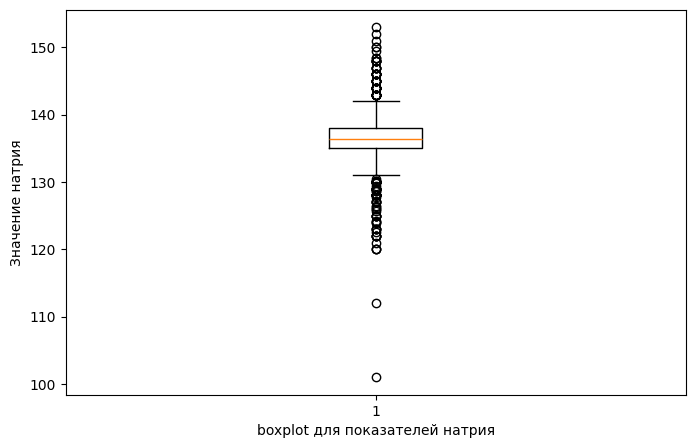

In [81]:
plt.figure(figsize=(8, 5))
plt.boxplot(df['Натрий'])
plt.ylabel('Значение натрия')
plt.xlabel('boxplot для показателей натрия')

## Feature engineering

### Преобразование категориальных переменных

In [21]:
num_var = [col for col in df.describe(exclude=[object]).keys() if col not in ['APACHE-2', 'ШКГ', 'id']]
print(num_var)

['Сутки н/з', 'Возраст', 'температура', 'пульс', 'АД ср', 'ЧД', 'Гематокрит', 'Лейкоциты', 'П/я', 'Юные', 'Лимфоциты', 'Общ белок (г/л)', 'Билирубин общ', 'АСТ', 'АЛТ', 'Мочевина', 'Креатинин', 'Калий', 'Натрий', 'Глюкоза крови', 'Диастаза мочи', 'Амилаза крови']


In [22]:

category_variables = [
    'Пол',
    'октреотид',
    'квамател',
    'антибиотик',
    'познее питание',
    'раннее питание',
    # 'Летальность',
    'ШКГ'
]

for variable in category_variables:
    print(
        f"Количество уникальных значений {df[variable].name}: {len(df[variable].unique())}"
    )

Количество уникальных значений Пол: 2
Количество уникальных значений октреотид: 2
Количество уникальных значений квамател: 2
Количество уникальных значений антибиотик: 7
Количество уникальных значений познее питание: 2
Количество уникальных значений раннее питание: 2
Количество уникальных значений ШКГ: 6


Создаю дадафрейм только с необходимыми переменными

In [23]:
data = df[category_variables]
data

,Пол,октреотид,квамател,антибиотик,познее питание,раннее питание,ШКГ
0,мужской,да,да,Карбопенемы,нет,да,15.0
1,мужской,да,нет,Карбопенемы,нет,да,15.0
2,мужской,да,да,Карбопенемы,нет,да,15.0
3,женский,нет,да,Карбопенемы,нет,да,15.0
4,мужской,да,да,Карбопенемы,нет,да,15.0
...,...,...,...,...,...,...,...
659,мужской,нет,нет,без антибиотика,нет,нет,15.0
660,мужской,да,да,без антибиотика,нет,нет,13.0
661,мужской,нет,нет,без антибиотика,нет,нет,15.0
662,женский,нет,нет,без антибиотика,нет,нет,15.0


Преобразую категориальные переменные с помощью OnrHotEncoder

In [24]:
ohe = OneHotEncoder(sparse_output=False)
ohe.fit(data[category_variables])
ohe_data = ohe.transform(data)
print(ohe_data.shape)
ohe_data

(664, 23)


array([[0., 1., 1., ..., 0., 0., 1.],
       [0., 1., 1., ..., 0., 0., 1.],
       [0., 1., 1., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 1., ..., 0., 0., 1.]])

Дополняю датафрейм перобразованными переменными

In [25]:
df[ohe.get_feature_names_out()] = ohe_data
df.head(5)

,id,Сутки н/з,Возраст,Пол,APACHE-2,температура,пульс,АД ср,ЧД,ШКГ,...,познее питание_да,познее питание_нет,раннее питание_да,раннее питание_нет,ШКГ_8.0,ШКГ_10.0,ШКГ_12.0,ШКГ_13.0,ШКГ_14.0,ШКГ_15.0
0,5,1.0,23.0,мужской,10,36.000000,118.0,116.0,28.0,15.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,327,1.0,65.0,мужской,9,37.400000,94.0,120.0,24.0,15.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,374,1.0,53.0,мужской,4,36.600000,82.0,127.0,16.0,15.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,349,1.0,53.0,женский,9,36.400000,105.0,107.0,16.0,15.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,128,4.0,23.0,мужской,14,37.167428,110.0,110.0,26.0,15.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [26]:
columns_list = [
    'Сутки н/з', 
    'Возраст', 
    'температура', 
    'пульс', 
    'АД ср', 
    'ЧД', 
    'Гематокрит', 
    'Лейкоциты', 
    'П/я', 
    'Юные', 
    'Лимфоциты', 
    'Общ белок (г/л)', 
    'Билирубин общ', 
    'АСТ', 
    'АЛТ', 
    'Мочевина', 
    'Креатинин', 
    'Калий', 
    'Натрий', 
    'Глюкоза крови', 
    'Диастаза мочи', 
    'Амилаза крови', 
]
columns_std = [col + '_std' for col in columns_list]

data_num = df[columns_list]
data_num

,Сутки н/з,Возраст,температура,пульс,АД ср,ЧД,Гематокрит,Лейкоциты,П/я,Юные,...,Билирубин общ,АСТ,АЛТ,Мочевина,Креатинин,Калий,Натрий,Глюкоза крови,Диастаза мочи,Амилаза крови
0,1.000000,23.0,36.000000,118.0,116.000000,28.0,63.000000,15.0,10.0,0.0,...,23.468447,52.000000,81.0,11.000000,1.200000,4.600000,138.000000,7.900000,2048.000000,3142.000000
1,1.000000,65.0,37.400000,94.0,120.000000,24.0,50.000000,14.0,11.0,0.0,...,14.000000,181.000000,147.0,8.000000,0.900000,3.900000,136.000000,10.600000,438.667431,1900.000000
2,1.000000,53.0,36.600000,82.0,127.000000,16.0,40.000000,14.0,6.0,0.0,...,26.000000,401.000000,348.0,5.000000,1.000000,3.900000,137.000000,6.500000,438.667431,482.294524
3,1.000000,53.0,36.400000,105.0,107.000000,16.0,55.000000,11.0,5.0,0.0,...,14.000000,175.000000,55.0,7.000000,1.100000,3.000000,136.000000,6.000000,91.000000,482.294524
4,4.000000,23.0,37.167428,110.0,110.000000,26.0,39.379707,5.0,50.0,0.0,...,23.468447,81.000000,28.0,20.100000,4.400000,6.300000,131.000000,12.000000,16.000000,482.294524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659,4.000000,25.0,36.400000,68.0,93.300000,16.0,37.000000,6.7,0.0,0.0,...,5.300000,21.000000,11.0,2.000000,0.082000,3.824207,136.330556,7.709774,8.000000,482.294524
660,7.000000,52.0,36.000000,140.0,60.000000,20.0,84.000000,25.0,1.0,2.0,...,22.000000,3639.000000,481.0,17.700000,2.100000,3.824207,136.330556,10.500000,438.667431,482.294524
661,15.000000,29.0,36.800000,78.0,95.678867,18.0,43.600000,12.2,10.0,0.0,...,12.000000,109.774955,17.0,3.500000,0.930000,4.040000,137.000000,4.000000,438.667431,75.000000
662,15.000000,30.0,36.900000,76.0,95.000000,17.0,37.000000,6.7,1.0,0.0,...,8.000000,27.000000,14.0,7.683188,1.560582,5.300000,138.000000,3.900000,438.667431,52.000000


In [27]:
std_scaler = StandardScaler()
std_scaler.fit(data_num)
std_scaler_new = std_scaler.transform(data_num)
std_scaler_new

array([[-5.91937405e-01, -1.52914602e+00, -1.35657860e+00, ...,
         4.53852968e-02,  2.22041567e+00,  4.59042772e+00],
       [-5.91937405e-01,  1.05026161e+00,  2.70254511e-01, ...,
         6.89569490e-01,  7.84275547e-17,  2.44684029e+00],
       [-5.91937405e-01,  3.13288000e-01, -6.59364409e-01, ...,
        -2.88636137e-01,  7.84275547e-17,  9.81069551e-17],
       ...,
       [ 6.38615429e-01, -1.16065921e+00, -4.26959679e-01, ...,
        -8.85102983e-01,  7.84275547e-17, -7.02956057e-01],
       [ 6.38615429e-01, -1.09924475e+00, -3.10757314e-01, ...,
        -9.08961657e-01,  7.84275547e-17, -7.42652120e-01],
       [ 7.80678908e-17,  9.88847139e-01, -4.26959679e-01, ...,
        -6.22657571e-01,  7.84275547e-17, -7.84074100e-01]])

Добавляю новые фичи в исходный датасет

In [28]:
df[columns_std] = std_scaler_new
print(df.columns.to_list())
df.head(5)

['id', 'Сутки н/з', 'Возраст', 'Пол', 'APACHE-2', 'температура', 'пульс', 'АД ср', 'ЧД', 'ШКГ', 'Гематокрит', 'Лейкоциты', 'П/я', 'Юные', 'Лимфоциты', 'Общ белок (г/л)', 'Билирубин общ', 'АСТ', 'АЛТ', 'Мочевина', 'Креатинин', 'Калий', 'Натрий', 'Глюкоза крови', 'Диастаза мочи', 'Амилаза крови', 'антибиотик', 'квамател', 'октреотид', 'раннее питание', 'познее питание', 'Летальность', 'Пол_женский', 'Пол_мужской', 'октреотид_да', 'октреотид_нет', 'квамател_да', 'квамател_нет', 'антибиотик_Карбопенемы', 'антибиотик_Фтрохинолоны', 'антибиотик_ЦС-3', 'антибиотик_ЦС-4', 'антибиотик_без антибиотика', 'антибиотик_пенициллин', 'антибиотик_цефазолин', 'познее питание_да', 'познее питание_нет', 'раннее питание_да', 'раннее питание_нет', 'ШКГ_8.0', 'ШКГ_10.0', 'ШКГ_12.0', 'ШКГ_13.0', 'ШКГ_14.0', 'ШКГ_15.0', 'Сутки н/з_std', 'Возраст_std', 'температура_std', 'пульс_std', 'АД ср_std', 'ЧД_std', 'Гематокрит_std', 'Лейкоциты_std', 'П/я_std', 'Юные_std', 'Лимфоциты_std', 'Общ белок (г/л)_std', 'Билируб

,id,Сутки н/з,Возраст,Пол,APACHE-2,температура,пульс,АД ср,ЧД,ШКГ,...,Билирубин общ_std,АСТ_std,АЛТ_std,Мочевина_std,Креатинин_std,Калий_std,Натрий_std,Глюкоза крови_std,Диастаза мочи_std,Амилаза крови_std
0,5,1.0,23.0,мужской,10,36.000000,118.0,116.0,28.0,15.0,...,0.000000,-0.248776,-0.038612,0.579587,-0.098427,1.101825,0.320619,0.045385,2.220416e+00,4.590428e+00
1,327,1.0,65.0,мужской,9,37.400000,94.0,120.0,24.0,15.0,...,-0.415090,0.306691,0.383125,0.055360,-0.180318,0.107646,-0.063484,0.689569,7.842755e-17,2.446840e+00
2,374,1.0,53.0,мужской,4,36.600000,82.0,127.0,16.0,15.0,...,0.110981,1.253998,1.667507,-0.468866,-0.153021,0.107646,0.128568,-0.288636,7.842755e-17,9.810696e-17
3,349,1.0,53.0,женский,9,36.400000,105.0,107.0,16.0,15.0,...,-0.415090,0.280855,-0.204751,-0.119382,-0.125724,-1.170585,-0.063484,-0.407930,-4.796810e-01,9.810696e-17
4,128,4.0,23.0,мужской,14,37.167428,110.0,110.0,26.0,15.0,...,0.000000,-0.123903,-0.377280,2.169739,0.775071,3.516260,-1.023742,1.023591,-5.831594e-01,9.810696e-17


In [29]:
columns_for_drop = [
    'Пол',
    'октреотид',
    'квамател',
    'антибиотик',
    'познее питание',
    'раннее питание',
    # 'Летальность',
    'ШКГ',
    'Сутки н/з', 
    'Возраст', 
    'температура', 
    'пульс', 
    'АД ср', 
    'ЧД', 
    'Гематокрит', 
    'Лейкоциты', 
    'П/я', 
    'Юные', 
    'Лимфоциты', 
    'Общ белок (г/л)', 
    'Билирубин общ', 
    'АСТ', 
    'АЛТ', 
    'Мочевина', 
    'Креатинин', 
    'Калий', 
    'Натрий', 
    'Глюкоза крови', 
    'Диастаза мочи', 
    'Амилаза крови',
    'APACHE-2'   
]

df_prepared = df.drop(columns=columns_for_drop)

In [30]:
print(df_prepared.shape)
df_prepared.columns.to_list()

(664, 47)


['id',
 'Летальность',
 'Пол_женский',
 'Пол_мужской',
 'октреотид_да',
 'октреотид_нет',
 'квамател_да',
 'квамател_нет',
 'антибиотик_Карбопенемы',
 'антибиотик_Фтрохинолоны',
 'антибиотик_ЦС-3',
 'антибиотик_ЦС-4',
 'антибиотик_без антибиотика',
 'антибиотик_пенициллин',
 'антибиотик_цефазолин',
 'познее питание_да',
 'познее питание_нет',
 'раннее питание_да',
 'раннее питание_нет',
 'ШКГ_8.0',
 'ШКГ_10.0',
 'ШКГ_12.0',
 'ШКГ_13.0',
 'ШКГ_14.0',
 'ШКГ_15.0',
 'Сутки н/з_std',
 'Возраст_std',
 'температура_std',
 'пульс_std',
 'АД ср_std',
 'ЧД_std',
 'Гематокрит_std',
 'Лейкоциты_std',
 'П/я_std',
 'Юные_std',
 'Лимфоциты_std',
 'Общ белок (г/л)_std',
 'Билирубин общ_std',
 'АСТ_std',
 'АЛТ_std',
 'Мочевина_std',
 'Креатинин_std',
 'Калий_std',
 'Натрий_std',
 'Глюкоза крови_std',
 'Диастаза мочи_std',
 'Амилаза крови_std']

летальность перевожу в 0 и 1

Сохраняю финальный датасет в новый файл

In [31]:
df_prepared.to_csv('final_prepared.csv', index=False)

# Modelling

### 1. RandomForest

Формирую датасет для обучения и делю его на train и test

In [32]:
df_prep = pd.read_csv('final_prepared.csv')

In [33]:
df_forest = df_prep.copy()
df_forest = df_forest.drop(['id'], axis=1)

x = df_forest.drop(['Летальность'], axis=1)
y = df_forest['Летальность']

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

Обучаю модель RandomForest

In [34]:
rf_clf = RandomForestClassifier(
    n_estimators=150, 
    min_samples_split=3, 
    bootstrap=False, 
    random_state=42, 
    max_depth=80,
)

rf_clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=80, min_samples_split=3,
                       n_estimators=150, random_state=42)

In [35]:
predicted_train_rf = rf_clf.predict(x_train)
predicted_test_rf = rf_clf.predict(x_test)

print(accuracy_score(y_train, predicted_train_rf))
print(accuracy_score(y_test, predicted_test_rf))

1.0
0.8045112781954887


In [36]:
f_imp_list = list(zip(x_train.columns, rf_clf.feature_importances_))
f_imp_list.sort(key=lambda x: x[1], reverse=True)
f_imp_list

[('Креатинин_std', 0.0835116259106101),
 ('Мочевина_std', 0.07005687567680988),
 ('АД ср_std', 0.06569497201624025),
 ('ЧД_std', 0.05868139153542664),
 ('П/я_std', 0.047793147561877906),
 ('Возраст_std', 0.047522888516871455),
 ('Калий_std', 0.04324234265099928),
 ('Глюкоза крови_std', 0.042699987544950996),
 ('Амилаза крови_std', 0.0410443056120668),
 ('АСТ_std', 0.03733830811646141),
 ('температура_std', 0.03534163646855175),
 ('Гематокрит_std', 0.03498627711462473),
 ('Натрий_std', 0.034024901628093),
 ('Лейкоциты_std', 0.03401700035344585),
 ('пульс_std', 0.033541635844228715),
 ('Лимфоциты_std', 0.03207482708530091),
 ('Общ белок (г/л)_std', 0.03202873672710465),
 ('АЛТ_std', 0.029999739631278603),
 ('Диастаза мочи_std', 0.028665550611486287),
 ('Сутки н/з_std', 0.027765468071513963),
 ('Билирубин общ_std', 0.02758272026135027),
 ('Юные_std', 0.017597348775627405),
 ('познее питание_нет', 0.011414897509963601),
 ('познее питание_да', 0.010386912973641062),
 ('ШКГ_15.0', 0.00931683

Кросс-валидация

In [37]:
cross_validate(rf_clf, x, y, cv=5)

{'fit_time': array([0.42995167, 0.3920927 , 0.3919704 , 0.38794947, 0.37045956]),
 'score_time': array([0.01185989, 0.01102757, 0.01097941, 0.01094866, 0.01091433]),
 'test_score': array([0.30075188, 0.72932331, 0.7518797 , 0.7593985 , 0.8030303 ])}

In [38]:
cv_score = cross_val_score(rf_clf, x, y, cv=5)

In [39]:
print(cv_score.mean())
print(cv_score.std())

0.66887673729779
0.18560741281409163


### 2. LogisticRegression

Формирую датасет для обучения и делю его на train и test

In [40]:
logreg_df = df_prep.copy()
x = logreg_df.drop(['Летальность', 'id'], axis=1)
y = logreg_df['Летальность']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Обучаю модель логистической регрессии

In [41]:
lr = LogisticRegression(
    C=3,
    max_iter=400,
    random_state=42,
    )
lr.fit(x_train, y_train)

LogisticRegression(C=3, max_iter=400, random_state=42)

In [42]:
lr_imp_list = list(zip(lr.coef_[0], lr.feature_names_in_))
lr_imp_list.sort(key=lambda x: x[0], reverse=True)
lr_imp_list
# lr.feature_names_in_

[(0.7768377643610735, 'ШКГ_12.0'),
 (0.6839862113236965, 'антибиотик_Фтрохинолоны'),
 (0.6589673411852354, 'ШКГ_13.0'),
 (0.6575443554975342, 'ШКГ_15.0'),
 (0.607331820874447, 'антибиотик_цефазолин'),
 (0.44328998281015525, 'познее питание_нет'),
 (0.37580610181079394, 'АЛТ_std'),
 (0.27694406397360116, 'АД ср_std'),
 (0.26547155832169045, 'Креатинин_std'),
 (0.23869538515468663, 'ШКГ_14.0'),
 (0.2375326359698983, 'Гематокрит_std'),
 (0.18258594453442267, 'температура_std'),
 (0.1238580600812334, 'Натрий_std'),
 (0.06564133762412966, 'Лимфоциты_std'),
 (0.03986066351221023, 'Общ белок (г/л)_std'),
 (0.024453103589168593, 'раннее питание_нет'),
 (0.022571813518958334, 'квамател_да'),
 (0.021895672914503964, 'антибиотик_пенициллин'),
 (0.02082130164107906, 'Пол_мужской'),
 (0.0032054771564104254, 'антибиотик_ЦС-4'),
 (-0.004201875567130657, 'октреотид_нет'),
 (-0.025287546377678865, 'октреотид_да'),
 (-0.030236112921455616, 'антибиотик_ЦС-3'),
 (-0.030964474186871142, 'Диастаза мочи_std'

In [43]:
lr.coef_

array([[-0.05031072,  0.0208213 , -0.02528755, -0.00420188,  0.02257181,
        -0.05206124, -0.60337112,  0.68398621, -0.03023611,  0.00320548,
        -0.71230137,  0.02189567,  0.60733182, -0.4727794 ,  0.44328998,
        -0.05394253,  0.0244531 , -0.4132791 , -1.94825517,  0.77683776,
         0.65896734,  0.23869539,  0.65754436, -0.11215268, -0.44775986,
         0.18258594, -0.18107919,  0.27694406, -0.55901946,  0.23753264,
        -0.3287367 , -0.33796796, -0.1451438 ,  0.06564134,  0.03986066,
        -0.04475399, -0.8385246 ,  0.3758061 , -0.41893093,  0.26547156,
        -0.13912762,  0.12385806, -0.12768837, -0.03096447, -0.09676185]])

In [44]:
lr.score(x, y)

0.7966867469879518

In [45]:
logreg_pred_train = lr.predict(x_train)
print('accuracy train', accuracy_score(y_train, logreg_pred_train))

logreg_pred_test = lr.predict(x_test)
print('accuracy test' ,accuracy_score(y_test, logreg_pred_test))
print('confusion_matrix', confusion_matrix(y_test, logreg_pred_test))

accuracy train 0.800376647834275
accuracy test 0.7819548872180451
confusion_matrix [[15 19]
 [10 89]]


In [46]:
cv_score = cross_val_score(lr, x, y, cv=5)
print(cv_score.mean())
print(cv_score.std())

0.6567897015265436
0.1788900694038817


### 3. Многослойный персептрон

Формирую датасет для обучения и делю его на train и test

In [47]:
mlp_df = df_prep.copy()
x = mlp_df.drop(['Летальность', 'id'], axis=1)
y = mlp_df['Летальность']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [48]:
mlp = MLPClassifier(
    random_state=42, 
    max_iter=500, 
    hidden_layer_sizes=(100,40),
    )
mlp.fit(x_train, y_train)

MLPClassifier(hidden_layer_sizes=(100, 40), max_iter=500, random_state=42)

In [49]:
mlp_pred_train = mlp.predict(x_train)
print('accuracy train' ,accuracy_score(y_train, mlp_pred_train))

mlp_pred_test = mlp.predict(x_test)
print('accuracy test' ,accuracy_score(y_test, mlp_pred_test))

accuracy train 1.0
accuracy test 0.765


In [50]:
cv_score = cross_val_score(mlp, x, y, cv=5)
print(cv_score.mean())
print(cv_score.std())

0.6462519936204147
0.15565087632369018


# Results

Обучение модели на всем датасете

In [51]:
df_forest = df_prep.copy()
df_forest = df_forest.drop(['id'], axis=1)

x = df_forest.drop(['Летальность'], axis=1)
y = df_forest['Летальность']

In [52]:
rf_clf = RandomForestClassifier(
    n_estimators=150, 
    min_samples_split=3, 
    bootstrap=False, 
    random_state=42, 
    max_depth=80,
)

rf_clf.fit(x, y)

RandomForestClassifier(bootstrap=False, max_depth=80, min_samples_split=3,
                       n_estimators=150, random_state=42)

Сохраняю полученню модель

In [53]:
with open('model.pickle', 'wb') as file:
    pickle.dump(rf_clf, file)